In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
from pinns.prelude import *
from pinns.model import mlp
from pinns.domain import Sphere
from pinns.calc import laplace, div
from pinns.opt import run_epoch
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt

In [4]:
domain = Sphere(1., (0., 0., 0.))
x_dom = array(Sobol(3, seed=0).random_base2(10))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(8))
x_bnd = domain.transform_bnd(x_bnd)


In [5]:
def mag(x):
    return array([0., 0., 1.])


def phi2_solution(x, x_bnd):
    eps = 1e-7
    def g(y):
        n = y / norm(y, axis=-1)
        return dot(mag(y), n)
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return (4 * pi * 1. ** 2) / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)

In [6]:
_x_bnd = array(Sobol(2, seed=123).random_base2(15))
_x_bnd = domain.transform_bnd(_x_bnd)
phi_bnd = phi2_solution(x_bnd, _x_bnd)

In [7]:
from dataclasses import dataclass, field
from jaxopt.linear_solve import solve_cg


def rbf(x, y, gamma=1.):
    d = jnp.sum((x - y) ** 2, axis=-1)
    return exp(-gamma * d)


@partial(jit, static_argnames=('k', 'vectorized'))
def pairwise_kernel(k, x, y, vectorized=False, *args, **kwargs):
    if vectorized:
        def _k1(x):
            return k(x, y, *args, **kwargs)
        return vmap(_k1)(x)
    else:
        def _k2(x, y):
            return k(x, y, *args, **kwargs)
        return vmap(vmap(_k2, (None, 0)), (0, None))(x, y)


@dataclass(frozen=True)
class KRR:
    coef: ndarray
    support: ndarray
    kernel: Callable = field(compare=False)

    def __call__(self, x):
        K = self.kernel(x, self.support)
        return K @ self.coef


def krr(x, y, kernel, alpha, solver_kwargs=None, *args, **kwargs) -> KRR:
    @wraps(kernel)
    def _kernel(x, y):
        return pairwise_kernel(kernel, x, y, *args, **kwargs)
    K = _kernel(x, x)

    def matvec(x):
        return K @ x
    if solver_kwargs is None:
        kw = {}
    else:
        kw = solver_kwargs
    coef = solve_cg(matvec, y, ridge=alpha, **kw)
    return KRR(coef, x, _kernel)



In [94]:
model = krr(x_bnd, phi_bnd, rbf, 0.01, gamma=1.)
phi_bnd_krr = model(x_bnd)

print(phi_bnd[0:10])
print(phi_bnd_krr[0:10])

[-0.2302885   0.2252754   0.07535556 -0.0502371  -0.16493356  0.12453456
  0.32743844 -0.31237307 -0.25362784  0.2826315 ]
[-0.22941926  0.22487873  0.07654089 -0.05224959 -0.16459186  0.12491255
  0.3239435  -0.30475497 -0.25446182  0.28239897]


In [57]:
X = concatenate([x_bnd, x_dom])
gamma = 0.1

def compute_stiffness_matrix(kernel, data, support, *args, **kwargs):
    grad_rbf = grad(kernel)
    grad_rbf = pairwise_kernel(grad_rbf, data, support, *args, **kwargs)
    S = jnp.tensordot(grad_rbf, grad_rbf, ((0,2), (0,2)))
    return S / len(data)




In [58]:
Q = 2 / 3 * pi * compute_stiffness_matrix(rbf, X, X, gamma=gamma)
A = pairwise_kernel(rbf, x_bnd, X, gamma=gamma)
b = phi_bnd
c = zeros((len(X),))

In [92]:
from jaxopt import EqualityConstrainedQP
qp = EqualityConstrainedQP(tol=1e-7, refine_regularization=2., refine_maxiter=200, maxiter=1000)

sol = qp.run(params_obj=(Q, c), params_eq=(A, b)).params
coef = sol.primal

In [93]:
def sol(x):
    return pairwise_kernel(rbf, x, X, gamma=gamma) @ coef

In [94]:
y_sol = sol(x_dom)
y_analytic = x_dom[:, 2] / 3
mean((y_analytic - y_sol) ** 2)

DeviceArray(1.9552648e-05, dtype=float32)

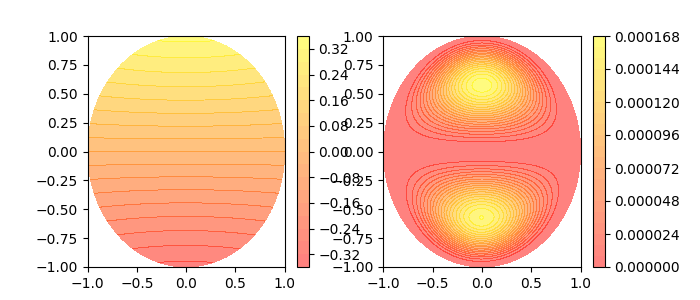

In [95]:
import itertools
import numpy as np

def plot_sol(sol, ax):
    plt.sca(ax)
    N = 1000
    x = np.linspace(-1, 1, N)
    z = np.linspace(-1, 1, N)
    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))
    phi[np.linalg.norm(X, axis=-1) > 1.] = np.nan

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)

fig = plt.figure(figsize=(7, 3))
ax1, ax2 = fig.subplots(1, 2)
plot_sol(lambda x: sol(x), ax1)
plot_sol(lambda x: (x[..., 2] / 3 - sol(x)) ** 2, ax2)

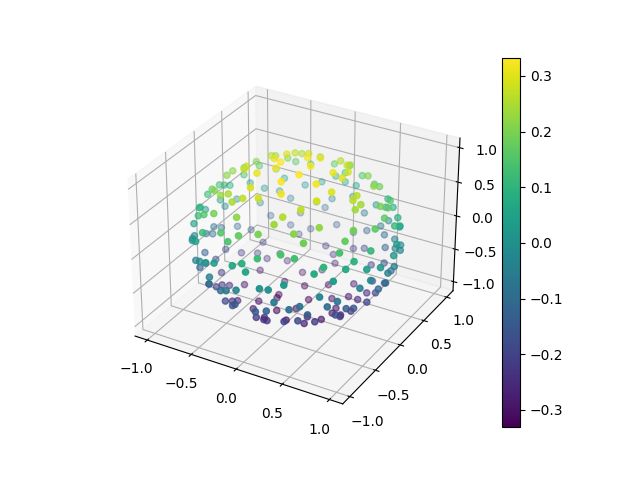

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(x_bnd[:, 0], x_bnd[:, 1], x_bnd[:, 2], c=phi_bnd[:])
plt.colorbar(p)